In [101]:
import os

# Set the working directory to the folder containing the notebook and dataset
os.chdir(r"C:\Users\lenovo\OneDrive\Documents\PROJECTS\ALT\Real-Estate-Image-Matching")

csv_file = "dataset/lamudi_data.csv"
print()

In [102]:
import pandas as pd
from transformers import CLIPProcessor 
from PIL import Image
import os
import clip, torch

In [103]:
def create_image_title_pairs(csv_file):
    df = pd.read_csv(csv_file)
    IDs = df["ID"].tolist()
    titles = df["Title"].tolist()
    image_title_pairs = []
    for i, ID in enumerate(IDs):
        if i > 5:
            break
        for i in range(1, 6):
            file_path = f"dataset/authentic_images/A{ID}.{i}.jpg"
            print(file_path)
            image = Image.open(file_path)
            x = int(ID)
            image_title_pairs.append((image, titles[x]))
            print(f'{image}, {titles[x]}')
    print(image_title_pairs[:5])  # Print the first 5 tuples
    
    return image_title_pairs  # Return both image paths and loaded images

In [104]:
# import os
# import pandas as pd
# from transformers import CLIPProcessor 
# from PIL import Image
# import clip, torch
# from torchvision import transforms

# # Define the image transformation to ensure images are converted to tensors
# transform = transforms.Compose([
#     transforms.Resize((224, 224)),
#     transforms.ToTensor()
# ])

# def create_image_title_pairs(csv_file):
#     df = pd.read_csv(csv_file)
#     IDs = df["ID"].tolist()
#     titles = df["Title"].tolist()
#     image_title_pairs = []
    
#     for i, ID in enumerate(IDs):
#         if i > 5:
#             break
#         for j in range(1, 6):
#             file_path = f"dataset/authentic_images/A{ID}.{j}.jpg"
#             print(file_path)
            
#             try:
#                 image = Image.open(file_path).convert("RGB")  # Convert to RGB
#                 image_tensor = transform(image)  # Convert image to tensor
#                 image_title_pairs.append((image_tensor, titles[int(ID)]))
#                 print(f'{image_tensor.shape}, {titles[int(ID)]}')
#             except Exception as e:
#                 print(f"Error processing image {file_path}: {e}")
    
#     print(image_title_pairs[:5])  # Print the first 5 tuples
#     return image_title_pairs  # Return both image paths and loaded images

In [105]:
csv_file = "dataset/lamudi_data.csv"
image_title_pairs = create_image_title_pairs(csv_file)
images, titles = zip(*image_title_pairs)

dataset/authentic_images/A1.1.jpg
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=450x450 at 0x2145A90E6D0>, 1 Bedroom w/ balcony For Sale Le Pont Tower 2, Bridgetowne Pasig City
dataset/authentic_images/A1.2.jpg
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=434x244 at 0x21457D63050>, 1 Bedroom w/ balcony For Sale Le Pont Tower 2, Bridgetowne Pasig City
dataset/authentic_images/A1.3.jpg
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=434x244 at 0x2145A90F310>, 1 Bedroom w/ balcony For Sale Le Pont Tower 2, Bridgetowne Pasig City
dataset/authentic_images/A1.4.jpg
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=244x244 at 0x21457BF7C10>, 1 Bedroom w/ balcony For Sale Le Pont Tower 2, Bridgetowne Pasig City
dataset/authentic_images/A1.5.jpg
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=244x244 at 0x2145A8F9110>, 1 Bedroom w/ balcony For Sale Le Pont Tower 2, Bridgetowne Pasig City
dataset/authentic_images/A2.1.jpg
<PIL.WebPImagePlugin.WebPImageFile i

In [106]:
import clip, torch
# OpenAI CLIP model and preprocessing
model, preprocess = clip.load("ViT-B/32", jit=False)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

CLIP(
  (visual): VisionTransformer(
    (conv1): Conv2d(3, 768, kernel_size=(32, 32), stride=(32, 32), bias=False)
    (ln_pre): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
    (transformer): Transformer(
      (resblocks): Sequential(
        (0): ResidualAttentionBlock(
          (attn): MultiheadAttention(
            (out_proj): NonDynamicallyQuantizableLinear(in_features=768, out_features=768, bias=True)
          )
          (ln_1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
          (mlp): Sequential(
            (c_fc): Linear(in_features=768, out_features=3072, bias=True)
            (gelu): QuickGELU()
            (c_proj): Linear(in_features=3072, out_features=768, bias=True)
          )
          (ln_2): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        )
        (1): ResidualAttentionBlock(
          (attn): MultiheadAttention(
            (out_proj): NonDynamicallyQuantizableLinear(in_features=768, out_features=768, bias=True)
          

In [107]:
import matplotlib.pyplot as plt
import matplotlib.text as mtext
import pandas as pd

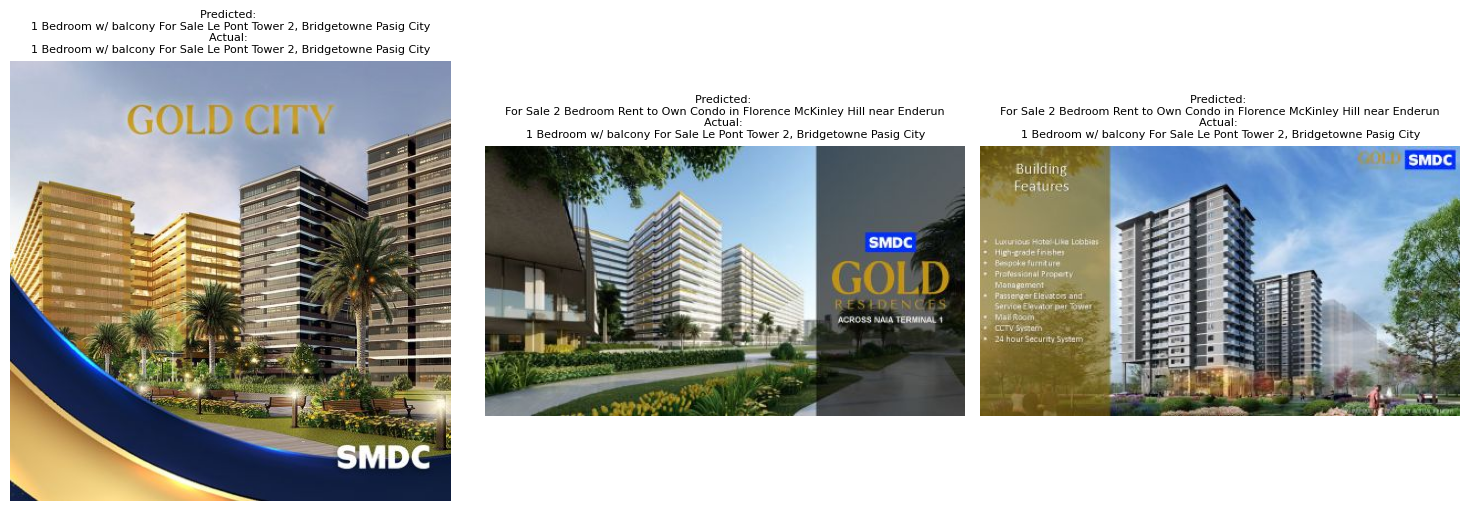

In [108]:
# Select indices for three example images
indices = [2, 3, 4]

# Preprocess the text for each title
text_inputs = torch.cat([clip.tokenize(f"a photo of {title}") for title in titles]).to(device)

# Create a figure with subplots
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

# Loop through the indices and process each image
for i, idx in enumerate(indices):
    # Select an example image from the dataset
    image = images[i]
    title = titles[i]

    # Preprocess the image
    image_input = preprocess(image).unsqueeze(0).to(device)

    # Calculate image and text features
    with torch.no_grad():
        image_features = model.encode_image(image_input)
        text_features = model.encode_text(text_inputs)

    # Normalize the features
    image_features /= image_features.norm(dim=-1, keepdim=True)
    text_features /= text_features.norm(dim=-1, keepdim=True)

    # Calculate similarity between image and text features
    similarity = (100.0 * image_features @ text_features.T).softmax(dim=-1)
    values, indices = similarity[0].topk(1)

    # Display the image in the subplot
    axes[i].imshow(image)
    axes[i].set_title(f"Predicted: \n{titles[indices[0]]}\nActual: \n{title}",fontsize=8)
    axes[i].axis('off')

# Show the plot
plt.tight_layout()
plt.show()

### **4. Processing the Dataset**

First, we must split our dataset into training and validation sets. This step is crucial because it allows us to evaluate the performance of our machine learning model on unseen data, ensuring that the model generalizes well to new, real-world data rather than just the data it was trained on.

We take 80% of the original dataset to train our model and the remaining 20% as the validation data.

In [109]:
from torch.utils.data import random_split

# Split dataset into training and validation sets
train_size = int(0.8 * len(image_title_pairs))
val_size = len(image_title_pairs) - train_size
train_dataset, val_dataset = random_split(image_title_pairs, [train_size, val_size])

Next, we create a custom dataset class:

In [110]:
from torchvision import transforms
from torch.utils.data import Dataset

class RealEstateDataset(Dataset):
    def __init__(self, data, transform=None):
        self.data = data
        self.transform = transform

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        image, title = self.data[idx]  # Assuming each pair in data is (image, title)
        if self.transform:
            image = self.transform(image)  # Apply transformation if provided
        return image, title  # Return the transformed image and title

Determine appropriate mean and standard deviation (std) values to normalize the real estate image dataset

1. **Preprocess the images**:
This will resize and convert the PIL images to PyTorch tensors, which are suitable for numerical calculations.

In [111]:
# Define transformations
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
])

# Apply transformations to images
images = [transform(image) for image in images]
print(images[0].shape)

torch.Size([3, 224, 224])


3. **Calculate Mean and Standard Deviation**:
This code will calculate the mean and standard deviation across all pixels and channels of your images.

In [112]:
mean = torch.mean(torch.stack(images), dim=(0, 1, 2))
std = torch.std(torch.stack(images), dim=(0, 1, 2))

print(mean.shape)
print(std.shape)

print("Mean:", mean)
print("Standard Deviation:", std)

torch.Size([224])
torch.Size([224])
Mean: tensor([0.4713, 0.4706, 0.4732, 0.4752, 0.4706, 0.4662, 0.4672, 0.4751, 0.4865,
        0.4910, 0.4919, 0.5031, 0.5095, 0.5098, 0.5105, 0.5048, 0.4949, 0.4896,
        0.4918, 0.5041, 0.5090, 0.5079, 0.5072, 0.5061, 0.5063, 0.5099, 0.5168,
        0.5165, 0.5145, 0.5152, 0.5145, 0.5146, 0.5114, 0.5088, 0.5051, 0.4989,
        0.4981, 0.4983, 0.4978, 0.4984, 0.4980, 0.5001, 0.5057, 0.5040, 0.4968,
        0.4953, 0.4992, 0.4989, 0.4967, 0.4940, 0.4978, 0.5056, 0.5072, 0.5074,
        0.5072, 0.5085, 0.5081, 0.5115, 0.5115, 0.5130, 0.5223, 0.5287, 0.5312,
        0.5312, 0.5219, 0.5188, 0.5176, 0.5137, 0.5153, 0.5173, 0.5181, 0.5199,
        0.5153, 0.5142, 0.5160, 0.5149, 0.5193, 0.5217, 0.5235, 0.5216, 0.5239,
        0.5266, 0.5297, 0.5331, 0.5327, 0.5330, 0.5295, 0.5203, 0.5222, 0.5181,
        0.5172, 0.5213, 0.5227, 0.5250, 0.5237, 0.5346, 0.5433, 0.5437, 0.5364,
        0.5326, 0.5297, 0.5338, 0.5344, 0.5351, 0.5412, 0.5446, 0.5427, 0.5376

Using the Calculated Values:

Once you have the mean and standard deviation, you can use them in your transforms.Normalize operation:

In [113]:
# Define transformations (optional)
transform = transforms.Compose([
    transforms.Normalize((mean), (std))  # Normalize (replace with your values)
])

# Create training and validation datasets
train_dataset = RealEstateDataset(train_dataset, transform=transform)
val_dataset = RealEstateDataset(val_dataset, transform=transform)

Next, we create DataLoaders:

In [114]:
from torch.utils.data import DataLoader

# Create DataLoader for training and validation sets
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)

Next, we modify the model for fine-tuning:

In [115]:
import torch.nn as nn

# Modify the model to include a classifier for subcategories
class CLIPFineTuner(nn.Module):
    def __init__(self, model, num_classes):
        super(CLIPFineTuner, self).__init__()
        self.model = model
        self.classifier = nn.Linear(model.visual.output_dim, num_classes)

    def forward(self, x):
        with torch.no_grad():
            features = self.model.encode_image(x).float()  # Convert to float32
        return self.classifier(features)

Finally, we instantiate the fine-tuning model:

In [116]:
num_classes = len(titles)
model_ft = CLIPFineTuner(model, num_classes).to(device)

Amazing! We've set up everything we need to perform fine-tuning! Let's now define our loss function and optimizer.

### **5. Define Loss Function and Optimizer**

We define as follows:

In [117]:
import torch.optim as optim

# Define the loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model_ft.classifier.parameters(), lr=1e-4)

### **6. Fine-Tuning CLIP Model**

Let's break down the code in the training loop:

**Training:**

* `num_epochs`: Specifies the number of epochs (iterations over the entire training dataset).
* Training mode: The model is set to training mode using `model_ft.train()`.
* Progress bar: A progress bar (`tqdm`) is used to track the progress of the training loop, displaying the current epoch and running loss.
* Training steps:
  - For each batch of images and labels from `train_loader`:
    - Move the images and labels to the specified device (CPU or GPU).
    - Zero the gradients using `optimizer.zero_grad()`.
    - Forward pass: Compute the model's outputs.
    - Compute the loss using criterion.
    - Backward pass: Compute gradients using `loss.backward()`.
    - Update the model parameters using `optimizer.step()`.
    - Update the running loss.
    - Update the progress bar description with the average loss for the epoch.
- After each epoch, the average loss for the epoch is printed.

**Validation:**
- Evaluation mode: The model is set to evaluation mode using `model_ft.eval()`.
- Accuracy calculation:
  - Disable gradient computation with `torch.no_grad()`.
  - For each batch of images and labels from val_loader:
    - Move the images and labels to the specified device.
    - Forward pass: Compute the model's outputs.
    - Get the predicted labels by finding the class with the highest score using `torch.max`.
    - Update the total number of labels and the count of correct predictions.
  - Calculate and print the validation accuracy as a percentage.

**Save the Fine-Tuned Model:**
The state dictionary of the fine-tuned model is saved to a file named `'clip_finetuned.pth'`.

In [118]:
from tqdm import tqdm

# Number of epochs for training
num_epochs = 5

# Training loop
for epoch in range(num_epochs):
    model_ft.train()  # Set the model to training mode
    running_loss = 0.0  # Initialize running loss for the current epoch
    pbar = tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs}, Loss: 0.0000")  # Initialize progress bar

    for images, labels in pbar:
        images, labels = images.to(device), labels.to(device)  # Move images and labels to the device (GPU or CPU)
        optimizer.zero_grad()  # Clear the gradients of all optimized variables
        outputs = model_ft(images)  # Forward pass: compute predicted outputs by passing inputs to the model
        loss = criterion(outputs, labels)  # Calculate the loss
        loss.backward()  # Backward pass: compute gradient of the loss with respect to model parameters
        optimizer.step()  # Perform a single optimization step (parameter update)

        running_loss += loss.item()  # Update running loss
        pbar.set_description(f"Epoch {epoch+1}/{num_epochs}, Loss: {running_loss/len(train_loader):.4f}")  # Update progress bar with current loss

    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {running_loss/len(train_loader):.4f}')  # Print average loss for the epoch

    # Validation
    model_ft.eval()  # Set the model to evaluation mode
    correct = 0  # Initialize correct predictions counter
    total = 0  # Initialize total samples counter

    with torch.no_grad():  # Disable gradient calculation for validation
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)  # Move images and labels to the device
            outputs = model_ft(images)  # Forward pass: compute predicted outputs by passing inputs to the model
            _, predicted = torch.max(outputs.data, 1)  # Get the class label with the highest probability
            total += labels.size(0)  # Update total samples
            correct += (predicted == labels).sum().item()  # Update correct predictions

    print(f'Validation Accuracy: {100 * correct / total}%')  # Print validation accuracy for the epoch

# Save the fine-tuned model
torch.save(model_ft.state_dict(), 'clip_finetuned.pth')  # Save the model's state dictionary

Epoch 1/5, Loss: 0.0000:   0%|          | 0/1 [00:00<?, ?it/s]

TypeError: img should be Tensor Image. Got <class 'PIL.WebPImagePlugin.WebPImageFile'>